<a href="https://colab.research.google.com/github/cardstdani/practica-par/blob/main/PracticaParadigmas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Práctica Paradigmas 1**

In [ ]:
!pip install pyvis==0.3.1

Error al cargar el fichero tablero, usando tablero aleatorio...
Error al cargar el fichero secuencia, usando secuencia aleatoria...
Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,.,.,.,a
B,1,.,.,.,a,a
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,.,.
F,.,a,a,c,1,b



Turno: 0 Puntos:67
Almacen: [.] Actual: [1]
[5, 0] [[-inf, 42, 42, 42, 42, -inf], [-inf, 42, 42, 42, -inf, -inf], [42, 42, -inf, 42, -inf, -inf], [-inf, 42, 42, -inf, 42, -inf], [-inf, 42, -inf, -inf, 42, 42], [62, -inf, -inf, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,.,.,.,.,a
B,1,.,.,.,a,a
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,.,.
F,2,a,a,c,1,b



Turno: 1 Puntos:62
Almacen: [.] Actual: [a]
[4, 4] [[-inf, 63, 63, 63, 64, -inf], [-inf, 63, 63, 64, -inf, -inf], [65, 63, -inf, 61, -inf, -inf], [-inf, 65, 61, -inf, 62, -inf], [-inf, 60, -inf, -inf, 82, 63], [-inf, -inf, -inf, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,.,.,.,.,a
B,.,1,.,.,a,a
C,.,.,a,.,c,c
D,a,.,.,.,.,c
E,a,.,.,.,b,.
F,2,.,.,c,2,b



Turno: 2 Puntos:82
Almacen: [.] Actual: [1]
[4, 5] [[-inf, 57, 57, 57, 57, -inf], [57, -inf, 57, 57, -inf, -inf], [57, 57, -inf, 57, -inf, -inf], [-inf, 57, 57, 57, 57, -inf], [-inf, 57, 57, 57, -inf, 77], [-inf, 57, 57, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,1,.,.,.,a
B,.,.,.,.,a,a
C,.,.,a,.,c,c
D,a,.,.,.,.,c
E,a,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 3 Puntos:77
Almacen: [.] Actual: [a]
[2, 0] [[-inf, -inf, 78, 78, 79, -inf], [78, 78, 78, 79, -inf, -inf], [80, 78, -inf, 78, -inf, -inf], [-inf, 80, 78, 78, 78, -inf], [-inf, 80, 78, 78, -inf, -inf], [-inf, 78, 78, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,.,1,.,.,a
B,.,.,.,.,a,a
C,b,.,a,.,c,c
D,.,.,.,.,.,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 4 Puntos:80
Almacen: [.] Actual: [1]
[0, 1] [[-inf, 55, -inf, 55, 55, -inf], [55, 55, 55, 55, -inf, -inf], [-inf, 55, -inf, 55, -inf, -inf], [55, 55, 55, 55, 55, -inf], [55, 55, 55, 55, -inf, -inf], [-inf, 55, 55, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,1,.,1,.,a
B,.,.,.,.,a,a
C,b,.,a,.,c,c
D,.,.,.,.,.,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 5 Puntos:55
Almacen: [.] Actual: [1]
[0, 2] [[-inf, -inf, 30, -inf, 30, -inf], [30, 30, 30, 30, -inf, -inf], [-inf, 30, -inf, 30, -inf, -inf], [30, 30, 30, 30, 30, -inf], [30, 30, 30, 30, -inf, -inf], [-inf, 30, 30, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,.,1,.,1,a
B,.,1,.,.,a,a
C,b,.,a,.,c,c
D,.,.,.,.,.,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 6 Puntos:30
Almacen: [.] Actual: [a]
[0, 3] [[-inf, 31, -inf, 51, -inf, -inf], [31, -inf, 31, 32, -inf, -inf], [-inf, 31, -inf, 31, -inf, -inf], [31, 31, 31, 31, 31, -inf], [31, 31, 31, 31, -inf, -inf], [-inf, 31, 31, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,1,.,a,2,a
B,.,.,1,.,a,a
C,b,.,a,.,c,c
D,.,.,.,.,.,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 7 Puntos:51
Almacen: [.] Actual: [a]
[0, 2] [[-inf, -inf, 52, -inf, -inf, -inf], [52, 52, -inf, 52, -inf, -inf], [-inf, 52, -inf, 52, -inf, -inf], [52, 52, 52, 52, 52, -inf], [52, 52, 52, 52, -inf, -inf], [-inf, 52, 52, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,.,a,a,2,a
B,.,1,.,1,a,a
C,b,.,a,.,c,c
D,.,.,.,.,.,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 8 Puntos:52
Almacen: [.] Actual: [1]
[0, 1] [[-inf, 27, -inf, -inf, -inf, -inf], [27, -inf, 27, -inf, -inf, -inf], [-inf, 27, -inf, 27, -inf, -inf], [27, 27, 27, 27, 27, -inf], [27, 27, 27, 27, -inf, -inf], [-inf, 27, 27, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,1,a,a,2,a
B,.,.,1,.,a,a
C,b,.,a,1,c,c
D,.,.,.,.,.,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 9 Puntos:27
Almacen: [.] Actual: [a]
[1, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [28, 48, -inf, 27, -inf, -inf], [-inf, 28, -inf, -inf, -inf, -inf], [28, 28, 28, 28, 28, -inf], [28, 28, 28, 28, -inf, -inf], [-inf, 28, 28, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,.,a,.,1,a,a
C,b,.,a,.,c,c
D,.,.,.,1,.,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 10 Puntos:48
Almacen: [.] Actual: [a]
[1, 0] [[-inf, -inf, -inf, -inf, -inf, -inf], [51, -inf, 49, -inf, -inf, -inf], [-inf, 51, -inf, 49, -inf, -inf], [49, 49, 49, -inf, 49, -inf], [49, 49, 49, 49, -inf, -inf], [-inf, 49, 49, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,.,2,a,a,2,a
B,b,.,.,.,a,a
C,b,.,a,1,c,c
D,.,.,.,.,1,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 11 Puntos:51
Almacen: [.] Actual: [a]
[3, 3] [[52, -inf, -inf, -inf, -inf, -inf], [-inf, 52, 53, 51, -inf, -inf], [-inf, 52, -inf, -inf, -inf, -inf], [52, 52, 52, 72, -inf, -inf], [52, 52, 52, 52, -inf, -inf], [-inf, 52, 52, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,.,2,a,a,2,a
B,b,.,.,1,a,a
C,b,.,a,.,c,c
D,.,.,.,a,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 12 Puntos:72
Almacen: [.] Actual: [a]
[2, 3] [[73, -inf, -inf, -inf, -inf, -inf], [-inf, 73, 74, -inf, -inf, -inf], [-inf, 73, -inf, 75, -inf, -inf], [73, 73, 75, -inf, -inf, -inf], [73, 73, 73, 73, -inf, -inf], [-inf, 73, 73, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,.,2,a,a,2,a
B,b,.,1,.,a,a
C,b,.,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 13 Puntos:75
Almacen: [.] Actual: [a]
[0, 0] [[76, -inf, -inf, -inf, -inf, -inf], [-inf, 76, -inf, 75, -inf, -inf], [-inf, 76, 76, -inf, -inf, -inf], [76, 76, 76, 76, -inf, -inf], [76, 76, 76, 76, -inf, -inf], [-inf, 76, 76, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,.,.,1,a,a
C,b,.,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 14 Puntos:76
Almacen: [.] Actual: [b]
[1, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 91, 101, -inf, -inf, -inf], [-inf, 91, 81, -inf, -inf, -inf], [91, 81, 81, 81, -inf, -inf], [81, 81, 81, 81, -inf, -inf], [-inf, 81, 81, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,.,b,2,a,a
C,b,.,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 15 Puntos:101
Almacen: [.] Actual: [a]
[1, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 102, -inf, -inf, -inf, -inf], [-inf, 102, 102, -inf, -inf, -inf], [102, 102, 102, 102, -inf, -inf], [102, 102, 102, 102, -inf, -inf], [-inf, 102, 102, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,b,.,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 16 Puntos:102
Almacen: [.] Actual: [b]
[2, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 117, 117, -inf, -inf, -inf], [117, 107, 107, 107, -inf, -inf], [107, 107, 107, 107, -inf, -inf], [-inf, 107, 107, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,.,a,b,2,a,a
C,.,c,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 17 Puntos:117
Almacen: [.] Actual: [a]
[1, 0] [[-inf, -inf, -inf, -inf, -inf, -inf], [120, -inf, -inf, -inf, -inf, -inf], [118, -inf, 118, -inf, -inf, -inf], [118, 118, 118, 118, -inf, -inf], [118, 118, 118, 118, -inf, -inf], [-inf, 118, 118, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,.,2,a,a,2,a
B,b,.,b,2,a,a
C,.,c,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 18 Puntos:120
Almacen: [.] Actual: [a]
[0, 0] [[121, -inf, -inf, -inf, -inf, -inf], [-inf, 121, -inf, -inf, -inf, -inf], [121, -inf, 121, -inf, -inf, -inf], [121, 121, 121, 121, -inf, -inf], [121, 121, 121, 121, -inf, -inf], [-inf, 121, 121, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,.,b,2,a,a
C,.,c,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 19 Puntos:121
Almacen: [.] Actual: [a]
[1, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 122, -inf, -inf, -inf, -inf], [122, -inf, 122, -inf, -inf, -inf], [122, 122, 122, 122, -inf, -inf], [122, 122, 122, 122, -inf, -inf], [-inf, 122, 122, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,.,c,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 20 Puntos:122
Almacen: [.] Actual: [1]
[2, 0] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [97, -inf, 97, -inf, -inf, -inf], [97, 97, 97, 97, -inf, -inf], [97, 97, 97, 97, -inf, -inf], [-inf, 97, 97, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,1,c,.,b,c,c
D,.,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 21 Puntos:97
Almacen: [.] Actual: [1]
[2, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, 72, -inf, -inf, -inf], [72, 72, 72, 72, -inf, -inf], [72, 72, 72, 72, -inf, -inf], [-inf, 72, 72, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,.,c,1,b,c,c
D,1,.,.,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 22 Puntos:72
Almacen: [.] Actual: [a]
[3, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [73, -inf, -inf, -inf, -inf, -inf], [-inf, 73, 93, 73, -inf, -inf], [73, 73, 73, 73, -inf, -inf], [-inf, 73, 73, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,1,c,2,b,c,c
D,.,.,a,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 23 Puntos:93
Almacen: [.] Actual: [1]
[3, 0] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [68, 68, -inf, 68, -inf, -inf], [68, 68, 68, 68, -inf, -inf], [-inf, 68, 68, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,1,c,2,b,c,c
D,1,.,a,.,2,c
E,.,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 24 Puntos:68
Almacen: [.] Actual: [c]
[3, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 93, -inf, 93, -inf, -inf], [93, 93, 93, 93, -inf, -inf], [-inf, 93, 93, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,1,c,2,b,c,c
D,.,c,a,.,2,c
E,1,.,.,.,b,2
F,2,.,.,c,2,b



Turno: 25 Puntos:93
Almacen: [.] Actual: [a]
[3, 0] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [114, -inf, -inf, 94, -inf, -inf], [-inf, 94, 94, 94, -inf, -inf], [-inf, 94, 94, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,.,2,c
E,.,1,.,.,b,2
F,2,.,.,c,2,b



Turno: 26 Puntos:114
Almacen: [.] Actual: [a]
[3, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 115, -inf, -inf], [115, -inf, 115, 115, -inf, -inf], [-inf, 115, 115, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,a,2,c
E,.,.,1,.,b,2
F,2,.,.,c,2,b



Turno: 27 Puntos:115
Almacen: [.] Actual: [a]
[4, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [116, 116, -inf, 118, -inf, -inf], [-inf, 116, 116, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,1,.,2,c
E,.,.,.,b,b,2
F,2,.,.,c,2,b



Turno: 28 Puntos:118
Almacen: [.] Actual: [b]
[4, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 128, -inf, -inf], [123, 123, 133, -inf, -inf, -inf], [-inf, 123, 123, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,.,1,2,c
E,.,.,c,.,.,2
F,2,.,.,c,2,b



Turno: 29 Puntos:133
Almacen: [.] Actual: [a]
[3, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, 134, -inf, -inf, -inf], [134, 134, -inf, 134, 134, -inf], [-inf, 134, 134, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,.,2,c
E,.,.,c,1,.,2
F,2,.,.,c,2,b



Turno: 30 Puntos:134
Almacen: [.] Actual: [1]
[3, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 109, -inf, -inf], [109, 109, -inf, -inf, 109, -inf], [-inf, 109, 109, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,1,2,c
E,.,.,c,.,1,2
F,2,.,.,c,2,b



Turno: 31 Puntos:109
Almacen: [.] Actual: [1]
[4, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [84, 84, -inf, 224, -inf, -inf], [-inf, 84, 84, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,.,.,c
E,.,.,c,.,.,.
F,2,.,.,c,3,b



Turno: 32 Puntos:224
Almacen: [.] Actual: [b]
[3, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 229, 229, -inf], [229, 229, -inf, 229, 229, 229], [-inf, 229, 229, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,.,c
E,.,.,c,.,.,.
F,2,.,.,c,3,b



Turno: 33 Puntos:229
Almacen: [.] Actual: [w]
[0, 1] [[228, 234, 228, 228, 234, 228], [224, 228, 224, 234, 228, 228], [234, 204, 234, 224, 204, 204], [228, 204, 228, 224, -inf, 204], [-inf, -inf, 204, -inf, -inf, -inf], [234, -inf, -inf, 204, 179, 224]]


,0,1,2,3,4,5
A,a,.,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,.,c
E,.,.,c,.,.,.
F,2,.,.,c,3,b



Turno: 34 Puntos:234
Almacen: [.] Actual: [1]
[0, 1] [[-inf, 229, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 209, -inf], [209, 209, -inf, 209, 209, 209], [-inf, 209, 209, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,.,c
E,.,.,c,.,.,.
F,2,.,.,c,3,b



Turno: 35 Puntos:229
Almacen: [.] Actual: [a]
[3, 4] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 230, -inf], [230, 230, -inf, 230, 230, 230], [-inf, 230, 230, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,a,c
E,.,.,c,.,.,.
F,2,.,.,c,3,b



Turno: 36 Puntos:230
Almacen: [.] Actual: [1]
[4, 0] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [205, 205, -inf, 205, 205, 205], [-inf, 205, 205, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,a,c
E,1,.,c,.,.,.
F,2,.,.,c,3,b



Turno: 37 Puntos:205
Almacen: [.] Actual: [1]
[4, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 180, -inf, 180, 180, 180], [-inf, 180, 180, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,a,c
E,1,1,c,.,.,.
F,2,.,.,c,3,b



Turno: 38 Puntos:180
Almacen: [.] Actual: [1]
[4, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 155, 155, 155], [-inf, 155, 155, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,a,c
E,1,.,c,1,.,.
F,2,1,.,c,3,b



Turno: 39 Puntos:155
Almacen: [.] Actual: [1]
[4, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 130, -inf, -inf, 130, 130], [-inf, -inf, 130, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,a,c
E,1,1,c,.,1,.
F,2,.,1,c,3,b



Turno: 40 Puntos:130
Almacen: [.] Actual: [a]
[5, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 131, -inf, 131], [-inf, 236, -inf, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,b,c,c
D,a,c,a,b,a,c
E,.,.,c,.,1,.
F,3,a,1,c,3,b



Turno: 41 Puntos:236
Almacen: [.] Actual: [b]
[4, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [261, 261, -inf, 301, -inf, 261], [-inf, -inf, -inf, -inf, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,.,c,c
D,a,c,a,.,a,c
E,.,.,1,d,.,1
F,3,a,.,.,3,b



Turno: 42 Puntos:301
Almacen: [.] Actual: [a]
[4, 4] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 302, -inf, -inf], [-inf, -inf, -inf, 304, -inf, -inf], [302, 302, -inf, -inf, 322, -inf], [-inf, -inf, 302, 302, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,.,c,c
D,a,c,a,.,a,c
E,.,.,.,d,a,2
F,3,a,1,.,3,b



Turno: 43 Puntos:322
Almacen: [.] Actual: [a]
[3, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 323, -inf, -inf], [-inf, -inf, -inf, 324, -inf, -inf], [323, 323, 323, -inf, -inf, -inf], [-inf, -inf, -inf, 323, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,.,c,c
D,a,c,.,b,.,c
E,.,.,1,d,.,2
F,3,a,.,.,3,b



Turno: 44 Puntos:324
Almacen: [.] Actual: [a]
[2, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 325, -inf, -inf], [-inf, -inf, 325, -inf, 325, -inf], [325, 325, -inf, -inf, 325, -inf], [-inf, -inf, 325, 325, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,1,b,.,c
E,.,.,.,d,.,2
F,3,a,.,.,3,b



Turno: 45 Puntos:325
Almacen: [.] Actual: [a]
[4, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 326, -inf], [326, 326, 346, -inf, 326, -inf], [-inf, -inf, 326, 326, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,.,c
E,.,.,a,d,.,2
F,3,a,.,.,3,b



Turno: 46 Puntos:346
Almacen: [.] Actual: [a]
[4, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 347, -inf], [347, 349, -inf, -inf, 347, -inf], [-inf, -inf, 349, 347, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,.,c
E,.,b,.,d,.,2
F,3,.,.,.,3,b



Turno: 47 Puntos:349
Almacen: [.] Actual: [a]
[3, 4] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 350, -inf], [350, -inf, 350, -inf, 350, -inf], [-inf, 350, 350, 350, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,.,b,.,d,.,2
F,3,.,.,.,3,b



Turno: 48 Puntos:350
Almacen: [.] Actual: [a]
[4, 0] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [351, -inf, 351, -inf, 351, -inf], [-inf, 351, 351, 351, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,.,d,.,2
F,3,.,.,.,3,b



Turno: 49 Puntos:351
Almacen: [.] Actual: [a]
[4, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, 352, -inf, 352, -inf], [-inf, 352, 352, 352, -inf, -inf]]


,0,1,2,3,4,5
A,a,2,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 50 Puntos:352
Almacen: [.] Actual: [w]
[0, 1] [[351, 357, 351, 351, 357, 351], [347, 351, 347, 357, 351, 351], [357, 327, 357, 351, 327, 327], [351, 327, 357, 347, 351, 327], [351, 347, 351, 227, -inf, 357], [302, -inf, -inf, -inf, 302, 347]]


,0,1,2,3,4,5
A,a,.,a,a,2,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 51 Puntos:357
Almacen: [.] Actual: [w]
[0, 4] [[356, -inf, 356, 356, 362, 356], [352, 356, 352, 362, 356, 356], [362, 332, 362, 356, 332, 332], [356, 332, 362, 352, 356, 332], [356, 352, 356, 232, -inf, 362], [307, -inf, -inf, -inf, 307, 352]]


,0,1,2,3,4,5
A,a,.,a,a,.,a
B,b,a,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 52 Puntos:362
Almacen: [.] Actual: [a]
[0, 1] [[-inf, 363, -inf, -inf, 362, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 363, -inf], [-inf, 363, 363, 363, -inf, -inf]]


,0,1,2,3,4,5
A,.,b,.,.,.,a
B,b,.,b,2,a,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 53 Puntos:363
Almacen: [.] Actual: [a]
[0, 4] [[364, -inf, 364, 364, 365, -inf], [-inf, 364, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 364, -inf], [-inf, 364, 364, 364, -inf, -inf]]


,0,1,2,3,4,5
A,.,b,.,.,b,.
B,b,.,b,2,.,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 54 Puntos:365
Almacen: [.] Actual: [1]
[0, 0] [[360, -inf, 340, 340, -inf, 340], [-inf, 360, -inf, -inf, 340, 340], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 360, -inf], [-inf, 340, 340, 340, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,.,.,b,.
B,b,.,b,2,.,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 55 Puntos:360
Almacen: [.] Actual: [a]
[0, 2] [[-inf, -inf, 361, 361, -inf, 361], [-inf, 361, -inf, -inf, 361, 361], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 361, -inf], [-inf, 361, 361, 361, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,.,b,.
B,b,.,b,2,.,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 56 Puntos:361
Almacen: [.] Actual: [1]
[0, 3] [[-inf, -inf, -inf, 356, -inf, 336], [-inf, 356, -inf, -inf, 336, 336], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 356, -inf], [-inf, 336, 336, 336, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,2,b,.
B,b,.,b,2,.,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 57 Puntos:356
Almacen: [.] Actual: [1]
[1, 1] [[-inf, -inf, -inf, -inf, -inf, 331], [-inf, 351, -inf, -inf, 331, 331], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 351, -inf], [-inf, 331, 331, 331, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,2,b,.
B,b,2,b,2,.,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,.,2
F,3,.,.,.,3,b



Turno: 58 Puntos:351
Almacen: [.] Actual: [1]
[4, 4] [[-inf, -inf, -inf, -inf, -inf, 326], [-inf, -inf, -inf, -inf, 326, 326], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 346, -inf], [-inf, 326, 326, 326, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,2,b,.
B,b,2,b,2,.,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 59 Puntos:346
Almacen: [.] Actual: [a]
[0, 5] [[-inf, -inf, -inf, -inf, -inf, 347], [-inf, -inf, -inf, -inf, 347, 347], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 347, 347, 347, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,2,b,a
B,b,2,b,2,.,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 60 Puntos:347
Almacen: [.] Actual: [1]
[1, 4] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, 322, 322], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 322, 322, 322, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,2,b,a
B,b,2,b,2,1,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 61 Puntos:322
Almacen: [.] Actual: [a]
[1, 5] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, 408], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 323, 323, 323, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,.,b,a
B,b,2,b,3,.,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 62 Puntos:408
Almacen: [.] Actual: [a]
[1, 4] [[-inf, -inf, -inf, 409, -inf, -inf], [-inf, -inf, -inf, -inf, 411, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 409, 409, 409, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,.,b,.
B,b,2,b,3,b,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 63 Puntos:411
Almacen: [.] Actual: [a]
[0, 3] [[-inf, -inf, -inf, 412, -inf, 412], [-inf, -inf, -inf, -inf, -inf, 412], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 412, 412, 412, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,a,b,.
B,b,2,b,3,b,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 64 Puntos:412
Almacen: [.] Actual: [1]
[0, 5] [[-inf, -inf, -inf, -inf, -inf, 387], [-inf, -inf, -inf, -inf, -inf, 387], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 387, 387, 387, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,a,b,1
B,b,2,b,3,b,.
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 65 Puntos:387
Almacen: [.] Actual: [a]
[1, 5] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, 408], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 388, 388, 388, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,a,b,2
B,b,2,b,3,b,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,.,.,.,3,b



Turno: 66 Puntos:408
Almacen: [.] Actual: [a]
[5, 1] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, 409, 409, 409, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,a,b,2
B,b,2,b,3,b,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,a,.,.,3,b



Turno: 67 Puntos:409
Almacen: [.] Actual: [1]
[5, 2] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, 384, 384, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,a,b,2
B,b,2,b,3,b,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,a,1,.,3,b



Turno: 68 Puntos:384
Almacen: [.] Actual: [b]
[5, 3] [[-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, -inf, -inf, -inf], [-inf, -inf, -inf, 409, -inf, -inf]]


,0,1,2,3,4,5
A,2,b,a,a,b,2
B,b,2,b,3,b,a
C,2,c,2,a,c,c
D,a,c,2,b,a,c
E,a,b,a,d,2,2
F,3,a,2,b,3,b



Turno: 69 Puntos:409
Almacen: [.] Actual: [a]
Partida terminada, GG:👏


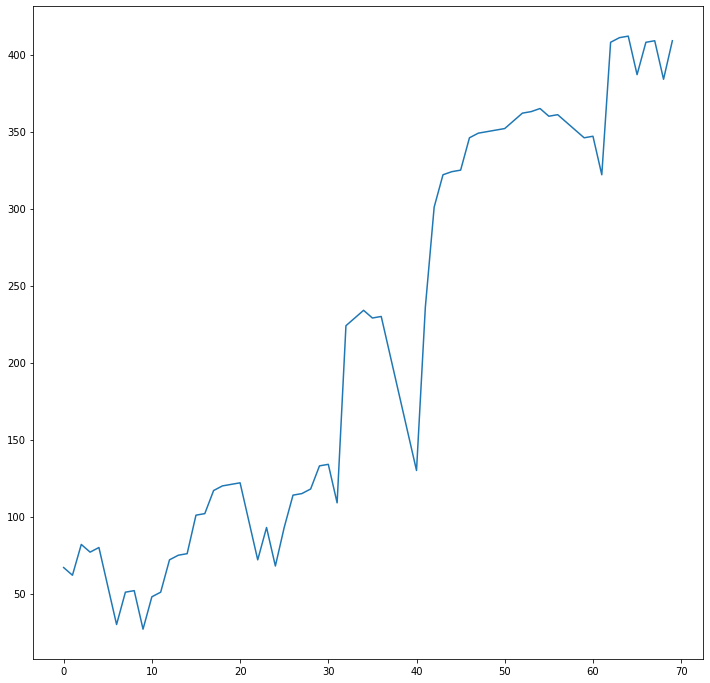

In [68]:
import random
import math
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

class TrieNode:
    def __init__(self, inputChar):
        self.char = inputChar
        self.end = False
        self.children = {}
 
class Trie():
    def __init__(self, startingElements=None):
        self.root = TrieNode("")
        if startingElements!=None:
          for i in startingElements: self.insert(i)
    def insert(self, word):
        node = self.root
        for char in word:
            if char in node.children:
                node = node.children[char]
            else:
                new_node = TrieNode(char)
                node.children[char] = new_node
                node = new_node
        node.end = True      
    def searchAndSplit(self, x):
        node = self.root
        output = ["", ""]
        for char in x:
            if char in node.children:
                node = node.children[char]            
            else:
                return []        
            output[1 if node.end else 0] += node.char
        return output if node.end else []
    def toGraph(self):
      from pyvis.network import Network
      g = Network(directed =True)      
      g.show_buttons()

      nodeIndex = 1
      currentNode = 0
      q = [self.root]      
      g.add_node(currentNode, label="", color="red")
      tempLabels = {0:""}
      while q!=[]:
        n = q.pop(0)                     
        for i in n.children.values():
          tempLabels[nodeIndex] = tempLabels[currentNode]+i.char
          g.add_node(nodeIndex, label=tempLabels[currentNode]+i.char, color="#48e073" if i.end else "blue")
          g.add_edge(currentNode, nodeIndex)
          nodeIndex+=1
          q.append(i)
        currentNode+=1
      g.show('nx.html')

class MainGame:
  def __init__(self):
    random.seed(368) #311
    self.objects = {".":[".",0],"a":["b",1],"b":["c",5],"c":["d",25],"d":["e",125],"e":["e",625],"1":["1",-25],"2":["3",-5],"3":["4",50],"4":["4",500],"x":["x",-50]}
    self.checkAndLoadFiles()    
    self.turn = 0
    self.score = []
    self.storage = "."
    self.bigFoots = [[[i,j], 0, False] for i in range(len(self.matrix)) for j in range(len(self.matrix[0])) if self.matrix[i][j]=="1"]    
    self.updateActual()
    self.tr = Trie((''.join(chr(97+int(j)) for j in str(i))+str(k) for k in range(len(self.matrix[0])) for i in range(len(self.matrix))))
    self.tr.insert("exit")
    self.tr.insert("hint")
    self.tr.insert("*")
    self.tr.toGraph()

  def checkAndLoadFiles(self):
    try:
      with open("tablero.txt", "r") as f:
        self.matrix=[]        
        for i in f.readlines():
          self.matrix.append([])
          for j in i.replace("\n", ""):
            if not j in self.objects: raise
            self.matrix[-1].append(j)
    except:
      self.matrix = [random.sample(["."]*45+["a"]*18+["b"]*4+["c"]*3+["1"]*2, 6) for i in range(6)]
      print("Error al cargar el fichero tablero, usando tablero aleatorio...")      
    try:
      with open("secuencia.txt", "r") as f:
        self.seq=""
        for i in f.readline():
          if i not in self.objects and i != "w": raise
          self.seq += i
    except:
      self.seq = ""
      print("Error al cargar el fichero secuencia, usando secuencia aleatoria...")      

  def main(self):
    print("Que empiece el juego:\U0001F609")
    self.showGame()    
    while any("." in x for x in self.matrix):
      message = self.validarEntrada("hint")#self.validarEntrada(input("Mover a casilla: ").lower().replace(" ", ""))
      while not message[0]: message = self.validarEntrada(input("Jugada errónea\nMover a casilla: ").lower().replace(" ", ""))

      if "".join(message[1])=="exit": break
      if "".join(message[1])=="*": self.storage=self.actual; self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*14+["w"]*1); self.showGame(); continue;
      coordinates = (lambda l: [int("".join([str(ord(i)%97) for i in l[0]])), int(l[1])])(message[1]) if "".join(message[1])!="hint" else self.getHint()
      if not ((self.matrix[coordinates[0]][coordinates[1]]==".") ^ (self.actual=="w")): print("Jugada errónea"); continue;

      self.updateMatrix(coordinates)
      self.updateActual()
      self.turn+=1
      self.bigFoots = [[i[0], i[1]+1, i[2]] for i in self.bigFoots]
      
      self.showGame()
    print("Partida terminada, GG:\U0001F44F")
    fig = plt.figure(figsize=(12, 12))
    plt.plot(list(range(len(self.score))), self.score)
    plt.show()

  def getHint(self):
    tempValues = [[-math.inf]*len(self.matrix[0]) for i in range(len(self.matrix))]
    for i in range(len(self.matrix)):
      for j in range(len(self.matrix[0])):
        if (self.matrix[i][j] == ".") ^ (self.actual=="w"): newObj = copy.deepcopy(g); newObj.updateMatrix([i,j]); tempValues[i][j] = sum(self.objects[b][1] for a in newObj.matrix for b in a)

    (col, val), row = max(map(lambda x: (max(enumerate(x[1]), key= lambda x: x[1]), x[0]), enumerate(tempValues)), key=lambda x: x[0][1])
    print([row, col], tempValues)
    return [row, col]
  
  def updateActual(self):
    self.actual = random.choice(["a"]*30+["b"]*5+["c"]*1+["1"]*14+["w"]*1) if self.seq=="" else self.seq[self.turn%len(self.seq)]
  
  def updateMatrix(self, coordinates):
    if self.actual=="w": self.matrix[coordinates[0]][coordinates[1]] = "."; self.deleteBigFoot(coordinates); return;
    self.matrix[coordinates[0]][coordinates[1]] = self.actual
    if self.actual=="1": self.bigFoots.append([coordinates, 0, False]); self.updateBigFoots(); return;

    self.checkAndColapse(coordinates)
    self.updateBigFoots()

  def checkAndColapse(self, coordinates):
    g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
    if g[1]=="2": coordinates = max(g[0], key=lambda x:[k for k in self.bigFoots if k[0]==x][0][1])
    while len(g[0])>2:
      for i in g[0]: 
        if self.matrix[i[0]][i[1]] == "2": self.deleteBigFoot(i);
        self.matrix[i[0]][i[1]] = "."
      self.matrix[coordinates[0]][coordinates[1]] = self.objects[g[1]][0]
      g = (self.getGroup(coordinates), self.matrix[coordinates[0]][coordinates[1]])
  
  def deleteBigFoot(self, coordinates):
    for i in range(len(self.bigFoots)):
      if self.bigFoots[i][0] == coordinates: del self.bigFoots[i]; break;

  def updateBigFoots(self):
    for i in enumerate(self.bigFoots):
      n = i[1][:]
      if not n[2] and n[1]>0:
        for j in (lambda l:[k for k in l if k[0]>=0 and k[1]>=0])(([n[0][0]-1, n[0][1]], [n[0][0], n[0][1]+1], [n[0][0]+1, n[0][1]], [n[0][0], n[0][1]-1])):
          try:
            if self.matrix[j[0]][j[1]]==".": self.matrix[j[0]][j[1]]="1"; self.matrix[n[0][0]][n[0][1]]="x" if n[1]>10 else "."; self.bigFoots[i[0]][0]=j[:]; break;
          except: pass

      if n[0]==self.bigFoots[i[0]][0]: 
        g = self.getGroup(n[0], True)
        if not "." in (self.matrix[k[0]][k[1]] for k in g):
          for j in g: self.matrix[j[0]][j[1]] = "2"; bfIndex = [k for k in range(len(self.bigFoots)) if self.bigFoots[k][0]==j][0]; self.bigFoots[bfIndex][2]=True;  
          self.checkAndColapse(n[0])

  def getGroup(self, coordinates, bigFootMode=False):    
    self.visitedMatrix = [[False]*len(self.matrix[0]) for i in range(len(self.matrix))]
    output = [coordinates]
    q = [coordinates]
    while q!=[]:
      n = q.pop(0)
      self.visitedMatrix[n[0]][n[1]] = True
      for i in (lambda l:[j for j in l if j[0]>=0 and j[1]>=0])([[n[0]-1, n[1]], [n[0], n[1]+1], [n[0]+1, n[1]], [n[0], n[1]-1]]):
        try:
          if (not self.visitedMatrix[i[0]][i[1]]) and (self.matrix[i[0]][i[1]]==self.matrix[coordinates[0]][coordinates[1]] or (bigFootMode and self.matrix[i[0]][i[1]]==".")): q.append(i); output.append(i);
        except:
          pass
    return output

  def validarEntrada(self, s):
    s = self.tr.searchAndSplit(s)
    return (True if s else False, s)

  def showGame(self):
    df = pd.DataFrame(self.matrix, columns=list(range(len(self.matrix[0]))), index=[''.join(chr(65+int(j)) for j in str(i)) for i in range(len(self.matrix))])
    display(HTML(df.to_html()))
    self.score.append(sum(self.objects[j][1] for i in self.matrix for j in i))
    print(f"\nTurno: {self.turn} Puntos:{self.score[-1]}\nAlmacen: [{self.storage}] Actual: [{self.actual}]")

if __name__=="__main__":
  g = MainGame()
  g.main()

**Bot Encoding**

In [ ]:
import copy
copyObj = copy.deepcopy(g)

In [ ]:
copyObj.__dict__

{'objects': {'.': ['.', 0],
  'a': ['b', 1],
  'b': ['c', 5],
  'c': ['d', 25],
  'd': ['e', 125],
  'e': ['e', 625],
  '1': ['1', -25],
  '2': ['3', -5],
  '3': ['4', 50],
  '4': ['4', 500],
  'x': ['x', -50]},
 'matrix': [['.', 'b', '1', '2', 'b', '1'],
  ['.', '.', '.', 'a', '3', '.'],
  ['.', '.', 'a', '.', 'c', 'c'],
  ['a', '.', '.', 'a', '.', 'c'],
  ['a', '.', 'a', 'a', '1', '.'],
  ['.', 'a', 'a', 'c', '.', 'b']],
 'seq': '',
 'turn': 9,
 'score': [67, 42, 43, 18, 20, -5, -30, 116, 116, 116, 116, 116, 119, 94],
 'storage': '.',
 'bigFoots': [[[4, 4], 9, False],
  [[0, 2], 9, False],
  [[0, 3], 7, True],
  [[0, 5], 1, False]],
 'actual': 'a',
 'tr': <__main__.Trie at 0x7f2aa84123d0>,
 'visitedMatrix': [[False, False, False, False, False, True],
  [False, False, False, False, False, True],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False],
  [False, False, False, False, False, False]]}

Que empiece el juego:😉


,0,1,2,3,4,5
A,a,.,a,2,b,.
B,.,1,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 7 Puntos:116
Almacen: [.] Actual: [a]
Mover a casilla: a1


,0,1,2,3,4,5
A,.,b,.,2,b,.
B,.,.,1,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,1,c
E,a,.,a,a,.,.
F,.,a,a,c,.,b



Turno: 8 Puntos:119
Almacen: [.] Actual: [1]
Mover a casilla: a5


,0,1,2,3,4,5
A,.,b,1,2,b,1
B,.,.,.,a,3,.
C,.,.,a,.,c,c
D,a,.,.,a,.,c
E,a,.,a,a,1,.
F,.,a,a,c,.,b



Turno: 9 Puntos:94
Almacen: [.] Actual: [a]
Mover a casilla: exit
Partida terminada, GG:👏


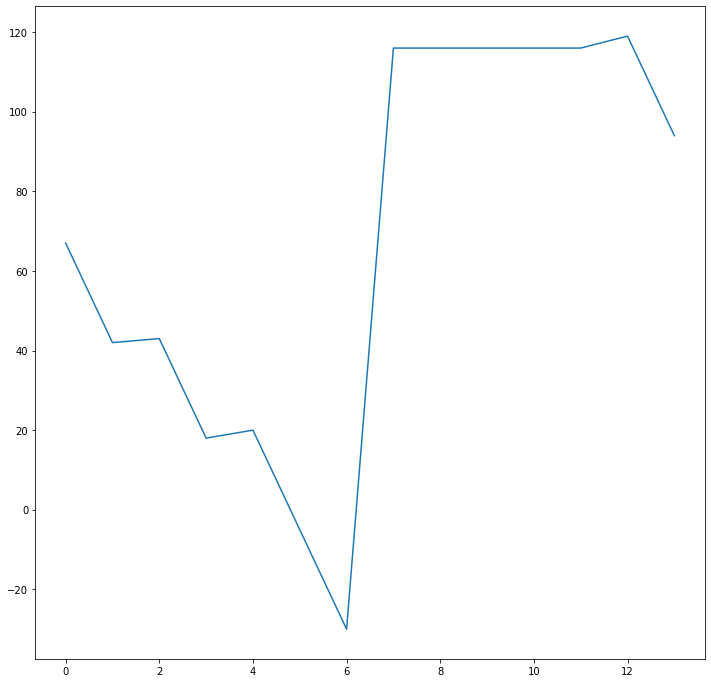

In [ ]:
copyObj.main()